In [2]:
from editor import Editor
from Box2D.b2 import pi

# edit your model by running this cell
# hit 's' to save while editing to model.json

editor = Editor()
editor.load('creatures/two_legs.json')
editor.run()

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from IPython.display import clear_output

import pygame
from pygame.locals import (KEYDOWN, K_RIGHT, K_LEFT, K_r, K_s)

from Box2D.b2 import pi

from agent import Agent
from engine import Engine

from time import sleep

# train your model to (hopefully) walk by running this cell
FILE = 'creatures/human.json'

TIMESTEPS = 500 # timesteps per episode

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True

ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0
engine = Engine(caption='Train', width=1600, height=600, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, linear_damping=0.0, angular_damping=0.0)

engine.load(FILE)

def features(time_step=0):
    f = []
    
    for b in engine.world.bodies:
        if b.userData and isinstance(b.userData, dict):
            a = b.angle % ANGLE_RANGE
            a /= ANGLE_RANGE
            a = a * 2.0 - 1.0
            f += [a]
            #f += [(engine.height - engine.to_screen(b.position)[0])/engine.height]
            #f += [np.sin(a), np.cos(a)]
            #f += [b.angularVelocity]
            #f += [b.linearVelocity[0]]
            #f += [b.linearVelocity[1]]
            
    
    #f += [float(time_step/TIMESTEPS * 2.0 - 1.0)]
    #f.append(np.sin(time_step/8.0))
            
    #for j in engine.world.joints:
    #    f.append(j.motorSpeed)
                
    return np.array([f])

# all joints change
"""s_format = '{:0' + str(len(engine.world.joints)) + 'b}'
def act(action):
    # joint config:
    config = s_format.format(action) # turn into binary rep
    for i, c in enumerate(config):
        engine.world.joints[i].motorSpeed = 5 if c == '1' else -5

action_count = 2**joint_count"""

# one joint at a time
"""
def act(action):
    #for j in engine.world.joints:
        #j.motorSpeed = 0.0
        
    #for b in engine.world.bodies:
        #if b.userData:
            #b.angularVelocity = 0
            #b.linearVelocity = (0, b.linearVelocity[1])
        
    motorSpeed = 4.0
    cnt = len(engine.world.joints)
    if action > cnt-1:
        motorSpeed *= -1
        action -= cnt
    joint = engine.world.joints[action]
    joint.motorSpeed = motorSpeed"""

rand_actions = [np.random.randn(len(engine.world.joints)) * 2.0 for i in range(8)]
def act(action):
    a = rand_actions[action]
    for i, j in enumerate(engine.world.joints):
        j.motorSpeed = a[i]
            
def body_position():
    avg = np.zeros([2])
    cnt = 0
    for b in engine.world.bodies:
        if b.userData:
            avg += [b.position[0], b.position[1]]
            cnt += 1
    avg /= cnt
    return engine.to_screen(avg)

def set_position(position, zero_vel=True):
    current = engine.to_pybox2d(body_position())
    position = engine.to_pybox2d(position)
    shift = (position[0] - current[0], position[1] - current[1])
    for b in engine.world.bodies:
        if b.userData:
            if zero_vel:
                b.linearVelocity = (0, 0)
                b.angularVelocity = 0
            b.position = (b.position[0] + shift[0], b.position[1] + shift[1])

action_count = len(rand_actions)
body_count = len(engine.world.bodies) - 1
joint_count = len(engine.world.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

agent = Agent(features=features().shape[1], actions=action_count, hdim=16, gamma=0.8, learning_rate=0.05, \
             max_memory=20000)
agent.eps = .3

rs = []
avg_r = 0.0

speedup = False
running = True
while running:
        
    if len(rs) > 1000:
            rs = rs[1000:]
            
    #train
    if len(agent.M) > 0:
        clear_output(wait=True)
        
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.show()
            
        if len(agent.M) > 100:
            agent.train(iters=128, batch_size=4, keep_prob=1.0)
            #vis_param(0)
            #plt.show()
            
    
    # timesteps
    t = 0
    
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    set_position((engine.width/2, engine.height/2))
    engine.step_physics(20)
    for b in engine.world.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
        
    
    last_x = body_position()[0]
    
    s1 = features(t)
    q1 = agent.qnet.ff(s1)
    a1 = agent.sample_action_eps(q1)
    
    reset = False
    while not reset:
        engine.clear_screen()
        
        for event in engine.events():
            if engine.quit_event(event):
                running = False
                reset = True
            if event.type == KEYDOWN:
                k = pygame.key.get_pressed()
                if k[K_RIGHT]:
                    agent.eps += .1
                elif k[K_LEFT]:
                    agent.eps -= .1
                elif k[K_r]:
                    agent.reset()
                elif k[K_s]:
                    speedup = not speedup

        # build xp tuple
        xp = {'s1': s1.copy(), 'a1': a1}
        
        # act a1
        act(a1)
        
        # step physics engine n times
        for i in range(15):
            engine.step_physics(1)
            if not speedup:
                engine.clear_screen()
                engine.render()
                engine.clock_tick()
        
        
        #for b in engine.world.bodies:
        #    b.linearVelocity = (0, 0)
        #    b.angularVelocity = 0
        
        # reward move right relative
        #reward = body_position()[0] - last_x
        #reward = min(max(reward, -2), 2)
        #reward *= -1
        
        # reward height
        new_p = body_position()
        reward = (engine.height - new_p[1]) / engine.height # stay high
        
        if new_p[1] > 500:
            reward = -1
            reset = True
        
        xp['r'] = reward
        
        avg_r += .001 * (reward - avg_r)
        rs.append(avg_r)
                             
        # state2
        s2 = features(t)
        q2 = agent.qnet.ff(s2)
        a2 = agent.sample_action_eps(q2)

        xp['s2'] = s2.copy()
        xp['a2'] = a2

        agent.memorize(xp)
        
        if t > TIMESTEPS:
            reset = True
        
        if not speedup:
            clear_output(wait=True)
            print('avg_r: {} eps: {} memories: {} action: {}'\
                  .format(np.round(avg_r, 1), agent.eps, len(agent.M), a2))
            print('s1: {}'.format(s1))
            #print('qs: {}'.format(agent.qnet.ff(s1)))
            engine.render()
            engine.clock_tick()

        # prepare for next rounds
        s1 = s2
        a1 = a2
        last_x = new_p[0]
        t += 1

        if last_x > engine.width-50.0 or last_x < 50.0:
            reset = True
            engine.render()
            engine.clock_tick()

engine.close()

avg_r: 0.1 eps: 0.3 memories: 390 action: 4
s1: [[ 0.52198566 -0.304367   -0.96469692  0.42531748 -0.67288056  0.10109035
  -0.68221206  0.30537784  0.28379875  0.52323212 -0.7588786   0.33248586]]


0.000676868


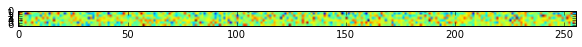

In [5]:
def vis_param(i):
    W = agent.qnet.params[i].eval(agent.qnet.session)
    try:
        plt.figure(figsize=(10, 10))
        fig = plt.imshow(W)
    except:
        pass
    print(np.mean(W))

vis_param(0)